In [1]:
# only permit vertex cover here
canonical_order = ['ENZYMES', 'MUTAG', 'COLLAB', 'PROTEINS', 'IMDB-BINARY', 'BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']
def reorder(df, canonical_order, by='dataset', extras=['dataset','gen_n'], secondary='gen_n'):
    df['dataset_name_order'] = df[by].map({name: i for i, name in enumerate(canonical_order)})
    if secondary is not None:
        df = df.sort_values(by=['dataset_name_order', secondary])
    else:
        df = df.sort_values(by=['dataset_name_order'])

    columnorder = [x for x in canonical_order if x in df.keys()]
    return df[extras + columnorder]

In [2]:
import os
os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs')

['legacy',
 'Testing',
 'LiftMP_runs',
 '230924_hparam2',
 '230927_snapshot',
 '230924_hparam',
 '230924_hparam_TU_multiarch',
 '230924_hparam_TU',
 '230926_finetune_ER_runs']

In [3]:
print(list(os.path.join('230927_snapshot', x) for x in os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot')))

['230927_snapshot/230925_TUsmall_GAT_VC', '230927_snapshot/230925_TUsmall_GIN_VC', '230927_snapshot/230925_generated_preset_cut', '230927_snapshot/230925_TUlarge_all_cut', '230927_snapshot/230925_TUsmall_GCNN_VC', '230927_snapshot/230925_generated_liftMP_VC', '230927_snapshot/230925_TUlarge_all_VC', '230927_snapshot/230925_generated_preset_VC', '230927_snapshot/230925_TUsmall_liftMP_VC', '230927_snapshot/230925_TUsmall_GatedGCNN_VC', '230927_snapshot/230925_generated_liftMP_cut']


In [4]:
run_folders = ['LiftMP_runs', '230927_snapshot/230925_TUsmall_GAT_VC', '230927_snapshot/230925_TUsmall_GIN_VC', 
               '230927_snapshot/230925_generated_preset_cut', '230927_snapshot/230925_TUlarge_all_cut', '230927_snapshot/230925_TUsmall_GCNN_VC',
                 '230927_snapshot/230925_generated_liftMP_VC', '230927_snapshot/230925_TUlarge_all_VC', '230927_snapshot/230925_generated_preset_VC', 
                 '230927_snapshot/230925_TUsmall_liftMP_VC', '230927_snapshot/230925_TUsmall_GatedGCNN_VC', '230927_snapshot/230925_generated_liftMP_cut']


In [5]:
import json
import pandas as pd
import numpy as np

folder_path = '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs'
model_list = [os.path.join(folder_path, run_folder, x) for run_folder in run_folders for x in os.listdir(os.path.join(folder_path, run_folder))  ]


rows = []

errored = []
for model_folder in model_list:
    try:
        with open(os.path.join(model_folder, 'params.txt'), 'r') as f:
            model_args = json.load(f)
        if model_args['problem_type'] != 'vertex_cover':
            continue
        
        losses = np.load(os.path.join(model_folder, 'valid_scores.npy'))
        test_losses = np.load(os.path.join(model_folder, 'test_scores.npy'))
        modeldict = model_args #{x: model_args[x] for x in params}
        modeldict['max_valid_score'] = max(losses)
        modeldict['max_valid_epoch'] = np.argmax(losses)
        modeldict['scores'] = test_losses[np.argmax(losses)]
        modeldict['baseline'] = False

        rows.append(modeldict)
        
    except Exception as e:
        print(f'{e} is wrong w/ {model_folder}')
        errored.append(model_folder)

[Errno 2] No such file or directory: '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/LiftMP_runs/paramhash:d7295454a183410793f153014e74c48fb81051635748e2fa4358e5e62ff747c8/valid_scores.npy' is wrong w/ /home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/LiftMP_runs/paramhash:d7295454a183410793f153014e74c48fb81051635748e2fa4358e5e62ff747c8
[Errno 2] No such file or directory: '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/LiftMP_runs/paramhash:959f4a30685c103490271cfaa513d24bffe58e4ff7f56301797ac56a2ab76978/valid_scores.npy' is wrong w/ /home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/LiftMP_runs/paramhash:959f4a30685c103490271cfaa513d24bffe58e4ff7f56301797ac56a2ab76978
[Errno 2] No such file or directory: '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/LiftMP_runs/paramhash:af7aa021f2876f5b35b4888f53a3bc63a8846a1ae09ca8bd2d6f8c1ee2f9923a/valid_scores.npy' is wrong w/ /home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/LiftMP_runs/paramhash:af7aa021f2876f5b35b4888f53a

In [6]:
len(errored)

162

In [7]:
# load in baselines
baselines = pd.read_csv('vc_baseline_scores.csv')

# unwind them 
for i, baseline in baselines.iterrows():
    #print(baseline.index)
    for col in baselines.keys():
        if col == 'Unnamed: 0':
            continue
        ds = col
        gen_n = np.nan
        if len(col.split('@@')) > 1:
            ds, gen_n = col.split('@@')
            gen_n = int(gen_n)

        row = {'dataset': ds, 'gen_n': gen_n, 'model_type': baseline['Unnamed: 0'], 'scores': baseline[col], 'baseline': True}
        #print(row)
        rows.append(row)


In [8]:
len(errored)

162

In [9]:
df = pd.DataFrame.from_records(rows)

In [10]:
df

,problem_type,seed,prefix,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,dropout,hidden_channels,...,RB_k,positional_encoding,pe_dimension,split_seed,log_dir,device,max_valid_score,max_valid_epoch,scores,baseline
0,vertex_cover,0.0,230925_generated_liftMP_VC,LiftMP,8.0,NaN,4.0,16.0,0.0,32.0,...,"[5, 21]",random_walk,8.0,0.0,training_runs/230925_generated_liftMP_VC/param...,cuda,-55.767000,4.0,-55.710000,False
1,vertex_cover,0.0,230925_TUsmall_liftMP_VC,LiftMP,16.0,NaN,4.0,4.0,0.0,32.0,...,"[5, 21]",random_walk,2.0,0.0,training_runs/230925_TUsmall_liftMP_VC/paramha...,cuda,-15.440000,98.0,-16.810000,False
2,vertex_cover,0.0,230925_TUsmall_liftMP_VC,LiftMP,16.0,NaN,4.0,16.0,0.0,32.0,...,"[5, 21]",random_walk,8.0,0.0,training_runs/230925_TUsmall_liftMP_VC/paramha...,cuda,-18.916667,14.0,-20.000000,False
3,vertex_cover,0.0,230925_generated_liftMP_VC,LiftMP,8.0,NaN,4.0,32.0,0.0,32.0,...,"[5, 21]",random_walk,16.0,0.0,training_runs/230925_generated_liftMP_VC/param...,cuda,-125.951000,1.0,-126.140000,False
4,vertex_cover,0.0,230925_TUsmall_liftMP_VC,LiftMP,16.0,NaN,4.0,4.0,0.0,32.0,...,"[5, 21]",laplacian_eigenvector,2.0,0.0,training_runs/230925_TUsmall_liftMP_VC/paramha...,cuda,-8.736842,8.0,-7.789474,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74.494800,True
878,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-32.633333,True
879,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
880,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [11]:
df['gen_n_max'] = df.gen_n.apply(lambda x: x[-1] if isinstance(x,list) else x)
df.gen_n = df.gen_n.apply(lambda x: x[0] if isinstance(x,list) else x)


In [12]:
df.keys()
# 'problem_type', 'seed',  'prefix', 'RB_n', 'RB_k', 'log_dir',
relevant_keys = [ 'model_type', 'num_layers',
       'repeat_lift_layers', 'num_layers_project', 'rank', 'vc_penalty', 'gen_n',
       'dataset', 'infinite',  'positional_encoding', 'pe_dimension',
       'max_valid_score', 'max_valid_epoch',
       'scores']

In [13]:
df

,problem_type,seed,prefix,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,dropout,hidden_channels,...,positional_encoding,pe_dimension,split_seed,log_dir,device,max_valid_score,max_valid_epoch,scores,baseline,gen_n_max
0,vertex_cover,0.0,230925_generated_liftMP_VC,LiftMP,8.0,NaN,4.0,16.0,0.0,32.0,...,random_walk,8.0,0.0,training_runs/230925_generated_liftMP_VC/param...,cuda,-55.767000,4.0,-55.710000,False,100.0
1,vertex_cover,0.0,230925_TUsmall_liftMP_VC,LiftMP,16.0,NaN,4.0,4.0,0.0,32.0,...,random_walk,2.0,0.0,training_runs/230925_TUsmall_liftMP_VC/paramha...,cuda,-15.440000,98.0,-16.810000,False,100.0
2,vertex_cover,0.0,230925_TUsmall_liftMP_VC,LiftMP,16.0,NaN,4.0,16.0,0.0,32.0,...,random_walk,8.0,0.0,training_runs/230925_TUsmall_liftMP_VC/paramha...,cuda,-18.916667,14.0,-20.000000,False,100.0
3,vertex_cover,0.0,230925_generated_liftMP_VC,LiftMP,8.0,NaN,4.0,32.0,0.0,32.0,...,random_walk,16.0,0.0,training_runs/230925_generated_liftMP_VC/param...,cuda,-125.951000,1.0,-126.140000,False,200.0
4,vertex_cover,0.0,230925_TUsmall_liftMP_VC,LiftMP,16.0,NaN,4.0,4.0,0.0,32.0,...,laplacian_eigenvector,2.0,0.0,training_runs/230925_TUsmall_liftMP_VC/paramha...,cuda,-8.736842,8.0,-7.789474,False,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74.494800,True,NaN
878,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-32.633333,True,NaN
879,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,50.0
880,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


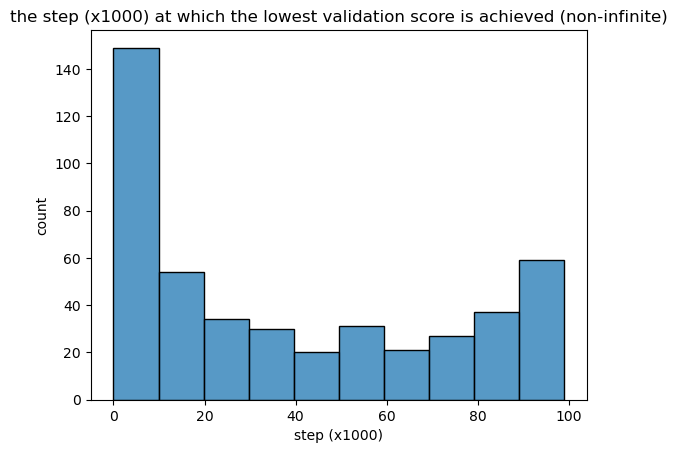

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
1,LiftMP,16.0,NaN,4.0,4.0,1.0,100.0,IMDB-BINARY,False,random_walk,2.0,-15.440000,98.0,-16.810000
118,LiftMP,16.0,NaN,4.0,4.0,1.0,100.0,ENZYMES,False,random_walk,2.0,-19.083333,93.0,-20.183333
143,LiftMP,16.0,NaN,4.0,4.0,1.0,100.0,COLLAB,False,laplacian_eigenvector,2.0,-65.660000,95.0,-67.734000
179,GAT,16.0,NaN,4.0,16.0,1.0,100.0,COLLAB,False,random_walk,8.0,-68.712000,93.0,-71.186000
180,GAT,8.0,NaN,4.0,32.0,1.0,100.0,PROTEINS,False,laplacian_eigenvector,8.0,-27.963964,94.0,-28.508929
189,GAT,8.0,NaN,4.0,32.0,1.0,100.0,COLLAB,False,laplacian_eigenvector,8.0,-66.390000,97.0,-68.606000
192,GAT,16.0,NaN,4.0,8.0,1.0,100.0,COLLAB,False,laplacian_eigenvector,4.0,-68.450000,98.0,-71.088000
197,GAT,8.0,NaN,4.0,32.0,1.0,100.0,IMDB-BINARY,False,laplacian_eigenvector,8.0,-17.420000,93.0,-18.930000
201,GAT,16.0,NaN,4.0,4.0,1.0,100.0,COLLAB,False,random_walk,2.0,-68.570000,95.0,-70.894000
203,GAT,8.0,NaN,4.0,16.0,1.0,100.0,ENZYMES,False,laplacian_eigenvector,8.0,-21.566667,93.0,-22.116667


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df[df.infinite==False].max_valid_epoch)
plt.title('the step (x1000) at which the lowest validation score is achieved (non-infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 90) & (df.infinite==False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

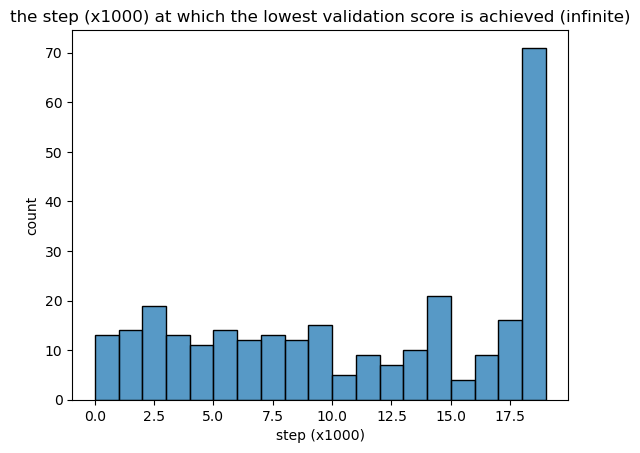

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
27,LiftMP,8.0,NaN,4.0,4.0,1.0,50.0,BarabasiAlbert,True,random_walk,2.0,-43.262,19.0,-43.245
33,LiftMP,16.0,NaN,4.0,4.0,1.0,50.0,ErdosRenyi,True,random_walk,2.0,-56.230,19.0,-56.227
34,LiftMP,16.0,NaN,4.0,32.0,1.0,50.0,BarabasiAlbert,True,random_walk,16.0,-42.921,19.0,-42.924
40,LiftMP,16.0,NaN,4.0,16.0,1.0,50.0,PowerlawCluster,True,random_walk,8.0,-43.066,19.0,-43.061
45,LiftMP,8.0,NaN,4.0,4.0,1.0,50.0,PowerlawCluster,True,random_walk,2.0,-43.418,19.0,-43.424
46,LiftMP,8.0,NaN,4.0,8.0,1.0,50.0,PowerlawCluster,True,random_walk,4.0,-43.112,19.0,-43.109
51,LiftMP,8.0,NaN,4.0,4.0,1.0,50.0,ErdosRenyi,True,random_walk,2.0,-56.543,19.0,-56.553
53,LiftMP,8.0,NaN,4.0,8.0,1.0,400.0,ErdosRenyi,True,random_walk,4.0,-422.420,19.0,-422.415
59,LiftMP,8.0,NaN,4.0,8.0,1.0,100.0,ErdosRenyi,True,random_walk,4.0,-126.472,19.0,-126.517
70,LiftMP,16.0,NaN,4.0,16.0,1.0,50.0,ErdosRenyi,True,random_walk,8.0,-55.595,19.0,-55.619


In [15]:
sns.histplot(df[df.infinite!=False].max_valid_epoch, bins=range(20))
plt.title('the step (x1000) at which the lowest validation score is achieved (infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 18) & (df.infinite!=False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

In [16]:
df.loc[df[df.baseline == False].groupby(['dataset', 'gen_n'])['scores'].idxmax()][relevant_keys]

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
52,LiftMP,16.0,NaN,4.0,16.0,1.0,50.0,BarabasiAlbert,True,random_walk,8.0,-42.891000,15.0,-42.882000
155,LiftMP,16.0,NaN,4.0,16.0,1.0,100.0,BarabasiAlbert,True,random_walk,8.0,-83.439000,11.0,-83.427000
150,LiftMP,16.0,NaN,4.0,8.0,1.0,400.0,BarabasiAlbert,True,random_walk,4.0,-248.469000,8.0,-248.735000
36,LiftMP,16.0,NaN,4.0,8.0,1.0,100.0,COLLAB,False,random_walk,4.0,-65.482000,35.0,-67.504000
2,LiftMP,16.0,NaN,4.0,16.0,1.0,100.0,ENZYMES,False,random_walk,8.0,-18.916667,14.0,-20.000000
13,LiftMP,16.0,NaN,4.0,8.0,1.0,50.0,ErdosRenyi,True,random_walk,4.0,-55.221000,18.0,-55.247000
59,LiftMP,8.0,NaN,4.0,8.0,1.0,100.0,ErdosRenyi,True,random_walk,4.0,-126.472000,19.0,-126.517000
171,LiftMP,8.0,NaN,4.0,16.0,1.0,400.0,ErdosRenyi,True,random_walk,8.0,-420.734000,19.0,-420.701000
24,LiftMP,16.0,NaN,4.0,32.0,1.0,100.0,IMDB-BINARY,False,random_walk,16.0,-15.420000,52.0,-16.760000
7,LiftMP,8.0,NaN,4.0,16.0,1.0,100.0,MUTAG,False,random_walk,8.0,-8.736842,0.0,-7.736842


In [17]:
df.gen_n = df.gen_n.fillna(100)

In [18]:
df.dataset

0           ErdosRenyi
1          IMDB-BINARY
2              ENZYMES
3        WattsStrogatz
4                MUTAG
            ...       
877             COLLAB
878            ENZYMES
879    PowerlawCluster
880             RANDOM
881           ForcedRB
Name: dataset, Length: 882, dtype: object

In [19]:
dataset_by_arc = pd.DataFrame()
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']
mts = ['SDP proj', 'gurobi_2.0', 'gurobi_4.0', 'gurobi_8.0', 'vertex count']



for (mt, ds, gen_n), group in df[(df.infinite == False) | (df.dataset == 'ErdosRenyi')].groupby(['model_type', 'dataset', 'gen_n']):
    if mt in mts:
        continue
    #print(mt, ds, gen_n)
    if ds in dss:
        dataset_by_arc.at[f'{ds}, {gen_n}', mt] = group['scores'].max()
    else: 
        dataset_by_arc.at[f'{ds}', mt] = group['scores'].max()


dataset_by_arc.rename(columns={'Nikos': 'CustomLiftProject'}, inplace=True)
dataset_by_arc[[k for k in dataset_by_arc.keys() if k != 'SDP lift']].to_csv('Table1_VC.csv')#.style.highlight_max(color = 'green', axis = 1)

In [20]:
dataset_by_arc = pd.DataFrame()
mts = ['GAT', 'GCNN', 'GIN', 'GatedGCNN']
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']

for (mt, ds, gen_n, gen_nmax), group in df[~df.model_type.isin(mts)].groupby(['model_type', 'dataset', 'gen_n', 'gen_n_max']):
    #print(mt, ds, gen_n)
    if ds in dss:
        k = f'{ds}_{gen_n}'
    else:
        k = ds
    dataset_by_arc.at[k, 'Type'] = ds
    dataset_by_arc.at[k, 'Nmin'] = gen_n
    dataset_by_arc.at[k, 'Nmax'] = gen_nmax
    dataset_by_arc.at[k, mt] = group['scores'].max()

#dataset_by_arc.rename(columns={'Nikos': 'CustomLiftProject'}, inplace=True)
dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in ['SDP lift', 'SDP proj', 'vertex count']]].to_csv('Table2_VC.csv') #.style.highlight_max(color = 'green', axis = 1)